# Data science 3 - Unsupervised final assignment
### Lecturer : Fenna Feenstra
### DSLS 2021
### Authur: Milad Toufani   -   Student number: 437689

### Assignment Unsupervised machine learning (due Monday June 13)

Choose one of the assignments (beginners, intermediate, advanced). Note that each of the assignments can lead to a sufficient mark, you should just choose the one you like the most. If you do not like one of the assignments, you can use your own dataset as well. Just make sure that you explain your choices! 

Beginners level

Dataset: primates-morphology
The file primates-morphology.csv contains coordinates derived from markers of skull features from various species of primates. 
Read the data in and use unsupervised machine learning methods to separate the groups belonging to different species. Do not forget to demonstrate a good working method and a non-working approach and explain why the method works or fails for this type of data. For each method that you try, give a short argument of why the method is worth trying. Make sure you properly inspect and preprocess the data (Check for missing data, skewness, distribution, sample, linearity, correlations etc.). 


## Frame the problem

## Load data

In [1]:
# Import packages
# Add libriries which used in my assignment
from datetime import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn import metrics
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
import matplotlib.colors as mcolors
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

In [2]:
#Other function

# helper function to color clusters
plt.rcParams['figure.figsize'] = [8,6]
def display_cluster(X,km,num_clusters, ax=plt):
    #color = 'brgcmkyw'
    color = list(mcolors.TABLEAU_COLORS.values())
    for i in range(num_clusters):
        #plot the datapoints in the color of the label
        ax.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = 0.4, s = 10)
        #plot the centroid
        ax.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], 
                    marker = '^', s = 300, alpha = 1)
    
    
# Function for reading csv files
def open_csv(input_file_name, skiprows=False, skiprow=0):
    """
    This function will open a .CSV file
    input:  - covid information in .CSV format
            - choose to skip rows (default = false)
            - How many rows to skip
    output: Dataframe
    """
    try:
        if skiprows is True:
            dataframe = pd.read_csv(input_file_name, skiprows=skiprow)
        else:
            dataframe = pd.read_csv(input_file_name, skiprows=0)
        return dataframe
    except FileNotFoundError:
        print('error, this file does not exist. please specify a .CSV file')

In [3]:
# Calling the function and create a dataframe
primates_df = open_csv('primates-morphology.csv')
primates_df.rename(columns = {"Unnamed: 0" : "id"}, inplace = True)

## Inspect the data and Prepare data

In [4]:
# Check the shape of the dataset
print(f"The shape of dataset is: {primates_df.shape}")
# Check if the dataset has NA data
print(f"Number of N/A value in dataframe: {primates_df.isnull().sum().sum()}")
# Check the type of columns
print(f"\nType of columns:\n {primates_df.dtypes}")

The shape of dataset is: (165, 36)
Number of N/A value in dataframe: 0

Type of columns:
 id                int64
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
10              float64
11              float64
12              float64
13              float64
14              float64
15              float64
16              float64
17              float64
18              float64
19              float64
20              float64
21              float64
22              float64
23              float64
24              float64
25              float64
26              float64
27              float64
28              float64
29              float64
Abbreviation     object
Genus            object
Species          object
Sex              object
Age              object
dtype: object


As I can see there is no missing value and no need to do any process

There are 30 features that we can use them for clustring

In [5]:
# Check the values for observation and see if it needs to be normalized
primates_df.head(10)

,id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,Abbreviation,Genus,Species,Sex,Age
0,37773,133.426742,-101.627603,21.125902,-11.518251,4.621089,-1.519551,0.583410,-7.182875,1.410030,...,-0.301822,-0.433051,0.037651,-0.279618,-0.421040,Ph,Presbytis,hosei,U,A
1,37772,145.344740,-108.229812,21.121390,-14.982879,2.299335,-2.354040,0.431199,-5.266930,-1.424469,...,0.215340,-0.299550,0.709472,0.876382,-0.150133,Ph,Presbytis,hosei,F,A
2,22276,137.773342,-107.162743,18.232497,-17.116294,3.016809,-5.295234,1.716895,-1.668914,-1.917478,...,-0.481468,-0.243025,-0.537644,-0.140292,0.082158,Pr,Presbytis,rubicunda,U,A
3,37776,141.523739,-107.436626,17.448083,-16.861469,3.382894,-1.071286,1.768891,-2.735232,-1.136700,...,0.586941,-0.043639,-0.518699,-1.051100,0.542354,Pr,Presbytis,rubicunda,M,A
4,37777,142.357906,-97.195294,10.511391,-6.520641,3.555506,1.652390,-0.655919,-5.373075,-1.466841,...,0.653851,0.718319,0.798722,-0.396749,0.844772,Pr,Presbytis,rubicunda,F,A
5,7088,127.190674,-98.588052,16.761627,-12.074791,5.065270,-3.748795,2.181976,-1.688401,3.655501,...,-0.102838,0.024416,-0.552922,0.056012,0.045076,Cm,Cercopithecus,mitis,F,A
6,39390,122.900607,-93.391053,16.829500,-4.604620,2.997883,1.034025,-0.458260,-1.942715,1.015997,...,0.432074,-0.814378,0.558849,-0.442273,-0.289274,Cm,Cercopithecus,mitis,U,A
7,44268,129.820266,-105.345031,13.053787,-14.213818,0.863442,-3.578397,0.768091,0.165735,1.528786,...,-2.037714,0.339314,0.334557,-0.180803,-0.217768,Cm,Cercopithecus,mitis,F,A
8,26832,136.305839,-103.012089,8.791377,-13.122486,1.354470,0.443781,-0.374986,-1.746728,1.739844,...,0.202322,0.232689,-0.301870,0.500481,-0.297675,Cm,Cercopithecus,mitis,F,A
9,39389,139.916374,-101.672292,10.385639,-8.242780,-0.515583,2.378753,-0.813230,-1.944177,0.553275,...,-0.860375,0.120151,0.026949,0.137547,0.181765,Cm,Cercopithecus,mitis,F,A


## Split data

I want to check which feature is better to choose

In [6]:
print("Number of unique Genus: {}".format(len(primates_df.Genus.value_counts())))
print("Value of different Genus: ")
print(primates_df.Genus.value_counts())
print("\n\n")
print("Number of unique Species: {}".format(len(primates_df.Species.value_counts())))
print("Value of different Species: ")
primates_df.Species.value_counts()

Number of unique Genus: 18
Value of different Genus: 
Colobus           20
Hylobates         18
Trachypithecus    18
Macaca            15
Presbytis         13
Pan               12
Cercopithecus     10
Papio              9
Nasalis            9
Cercocebus         9
Gorilla            6
Mandrillus         6
Lophocebus         6
Miopithecus        5
Erythrocebus       4
Symphalangus       2
Pongo              2
Theropithecus      1
Name: Genus, dtype: int64



Number of unique Species: 25
Value of different Species: 


cristata        18
lar             18
polykomos       10
mitis           10
badius          10
troglodytes      9
larvatus         9
anubis           9
torquatus        9
fascicularis     8
rubicunda        8
gorilla          6
albigena         6
talapoin         5
hosei            5
leucophaeus      4
patas            4
mulatta          3
paniscus         3
fuscata          2
sphinx           2
sylvanus         2
syndactylus      2
pygmaeus         2
gelada           1
Name: Species, dtype: int64

In [7]:
#primates_df = primates_df.set_index('id')

In [8]:
sel_data = primates_df.select_dtypes(include=np.number)

In [9]:
sel_data['Genus'] = primates_df[['Genus']].copy()
sel_data = sel_data.set_index('Genus')
sel_data.drop(['id'], axis=1 , inplace = True)

C:\Users\MF14C~1.TOU\AppData\Local\Temp/ipykernel_28712/2313103114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_data['Genus'] = primates_df[['Genus']].copy()


In [10]:
sel_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Genus,,,,,,,,,,,,,,,,,,,,,
Presbytis,133.426742,-101.627603,21.125902,-11.518251,4.621089,-1.519551,0.583410,-7.182875,1.410030,0.216411,...,-0.697783,-0.406979,0.607499,-1.309488,1.555190,-0.301822,-0.433051,0.037651,-0.279618,-0.421040
Presbytis,145.344740,-108.229812,21.121390,-14.982879,2.299335,-2.354040,0.431199,-5.266930,-1.424469,-1.451953,...,-0.105124,-0.569739,0.669346,-0.805954,1.583042,0.215340,-0.299550,0.709472,0.876382,-0.150133
Presbytis,137.773342,-107.162743,18.232497,-17.116294,3.016809,-5.295234,1.716895,-1.668914,-1.917478,0.601120,...,-0.546710,1.715016,1.269193,-0.397373,-0.813108,-0.481468,-0.243025,-0.537644,-0.140292,0.082158
Presbytis,141.523739,-107.436626,17.448083,-16.861469,3.382894,-1.071286,1.768891,-2.735232,-1.136700,-2.706925,...,-0.025537,0.972070,-0.066568,0.001964,0.656327,0.586941,-0.043639,-0.518699,-1.051100,0.542354
Presbytis,142.357906,-97.195294,10.511391,-6.520641,3.555506,1.652390,-0.655919,-5.373075,-1.466841,-2.626544,...,0.327166,-0.174675,0.368314,-0.700708,-0.450873,0.653851,0.718319,0.798722,-0.396749,0.844772
Cercopithecus,127.190674,-98.588052,16.761627,-12.074791,5.065270,-3.748795,2.181976,-1.688401,3.655501,1.240485,...,0.898888,-0.103932,0.169765,0.747697,1.057831,-0.102838,0.024416,-0.552922,0.056012,0.045076
Cercopithecus,122.900607,-93.391053,16.829500,-4.604620,2.997883,1.034025,-0.458260,-1.942715,1.015997,2.691627,...,0.861759,0.271740,0.387998,-0.280162,0.312138,0.432074,-0.814378,0.558849,-0.442273,-0.289274
Cercopithecus,129.820266,-105.345031,13.053787,-14.213818,0.863442,-3.578397,0.768091,0.165735,1.528786,4.128750,...,-1.449368,0.540887,-0.525799,0.715242,-0.319668,-2.037714,0.339314,0.334557,-0.180803,-0.217768
Cercopithecus,136.305839,-103.012089,8.791377,-13.122486,1.354470,0.443781,-0.374986,-1.746728,1.739844,0.217928,...,1.161659,0.341605,-0.328858,-0.419642,0.233434,0.202322,0.232689,-0.301870,0.500481,-0.297675


In [11]:
sel_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, Presbytis to Hylobates
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       165 non-null    float64
 1   1       165 non-null    float64
 2   2       165 non-null    float64
 3   3       165 non-null    float64
 4   4       165 non-null    float64
 5   5       165 non-null    float64
 6   6       165 non-null    float64
 7   7       165 non-null    float64
 8   8       165 non-null    float64
 9   9       165 non-null    float64
 10  10      165 non-null    float64
 11  11      165 non-null    float64
 12  12      165 non-null    float64
 13  13      165 non-null    float64
 14  14      165 non-null    float64
 15  15      165 non-null    float64
 16  16      165 non-null    float64
 17  17      165 non-null    float64
 18  18      165 non-null    float64
 19  19      165 non-null    float64
 20  20      165 non-null    float64
 21  21      165 non-null    float6

## Data exploration

In [12]:
sel_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,5.537129,1.196007,-0.125596,0.774423,-0.161111,-0.182550,-0.077955,0.180683,0.132617,-0.030271,...,0.057334,-0.014223,0.013269,-0.002892,0.005006,0.003208,-0.001137,-0.002748,-0.012738,-0.013131
std,99.061556,69.971050,56.627559,18.591984,11.336600,8.710069,5.463093,5.214248,4.520787,3.389125,...,1.254471,1.161247,0.971599,0.932425,0.865874,0.750532,0.720479,0.484438,0.461879,0.374258
min,-201.591249,-111.659165,-114.986835,-54.636918,-19.375303,-24.431319,-54.611282,-20.855026,-18.487708,-13.764311,...,-3.793245,-2.894577,-3.849517,-1.838070,-2.274559,-2.037714,-2.934118,-1.245955,-2.115305,-1.128128
25%,-58.767559,-44.542377,-45.981261,-12.328664,-7.348686,-5.823589,-1.389680,-2.572926,-2.279476,-1.834020,...,-0.697783,-0.739499,-0.482541,-0.585089,-0.587203,-0.413921,-0.411248,-0.300449,-0.320591,-0.248282
50%,-4.994670,18.343281,-2.090244,4.082730,-2.158090,-1.071286,-0.124301,-0.379776,-0.057433,-0.158941,...,0.086293,-0.103932,0.123128,-0.072030,-0.018886,-0.023107,-0.022457,0.001251,-0.018000,-0.010527
75%,89.480991,42.633134,32.805157,16.969797,3.716401,5.078963,1.575336,3.017432,3.199454,1.722897,...,0.784991,0.633467,0.526249,0.512882,0.621830,0.474782,0.418680,0.274560,0.277566,0.268744
max,192.170450,433.444316,142.161119,33.486208,68.005131,21.570367,18.598186,20.232449,18.859660,11.154277,...,3.300278,3.376167,3.423704,4.006407,3.131717,2.052453,2.727110,1.319978,1.653007,0.844772


See how much are they correlated and Can we eliminate certain features based on high correlations

In [13]:
corr_mat = sel_data.corr()
# Strip out the diagonal values for the next step
for x in range(len(sel_data.columns)):
    corr_mat.iloc[x,x] = 0.0

print("Maximum correlation for each feature: ")
print(corr_mat.abs().max())
print("---------------------------------------------------------------")
print("Maximum featuers correlations with each other: ")
print(corr_mat.abs().idxmax())

Maximum correlation for each feature: 
0     0.098790
1     0.043172
2     0.090029
3     0.094024
4     0.025959
5     0.052373
6     0.039426
7     0.051065
8     0.094024
9     0.055370
10    0.058318
11    0.049083
12    0.066572
13    0.098790
14    0.058954
15    0.090092
16    0.079309
17    0.083696
18    0.072537
19    0.045678
20    0.051799
21    0.090092
22    0.050297
23    0.031552
24    0.031496
25    0.083279
26    0.018560
27    0.057024
28    0.053242
29    0.066572
dtype: float64
---------------------------------------------------------------
Maximum featuers correlations with each other: 
0     13
1      2
2      8
3      8
4      7
5      0
6     15
7      3
8      3
9     12
10     2
11    16
12    29
13     0
14    12
15    21
16    21
17    21
18     8
19    12
20     3
21    15
22    15
23    14
24     7
25    15
26     0
27     0
28     2
29    12
dtype: object


Because the number of observations are not much enough, I would use Genus column as y axis and the other 0 to 29 columns as cordinates of x axis

In [14]:
# check for skenewss of data
skew = sel_data.skew()
skew = skew[skew > 0.75]
print(skew)


1     1.272854
4     2.358456
14    1.267799
23    0.782396
dtype: float64


As you said that the dataset is preprocessed before, we don't need to check for nomarlizing or centralizing

## Train model

In [15]:
# set the data
X = sel_data.iloc[:,0:].values #returns a numpy array
y = sel_data.index.values

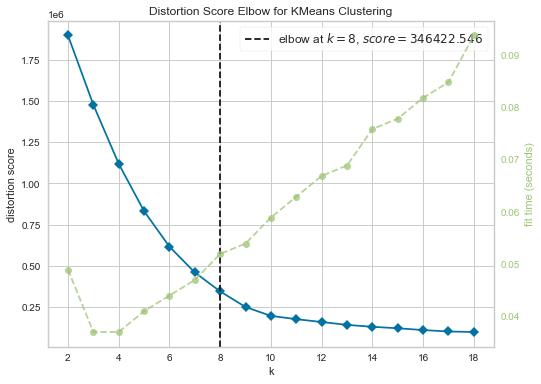

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
range_clusters = list(range(2,19))

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=range_clusters)
visualizer.fit(X)
visualizer.show()

In [17]:
# PCA
data = sel_data
pca=PCA()
pca.fit(data)
datatrans=pca.transform(data)
classes= sel_data.index.values
data_s = preprocessing.scale(data)
data_s = pd.DataFrame(data)

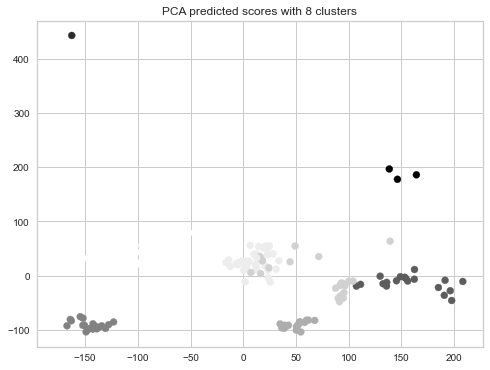

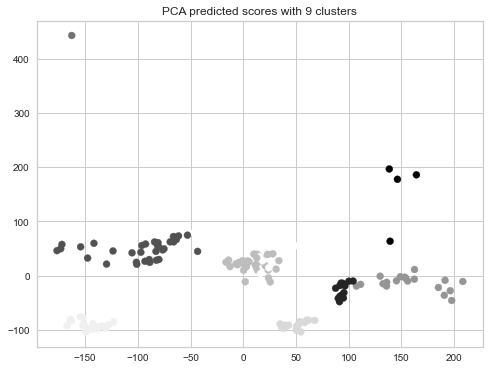

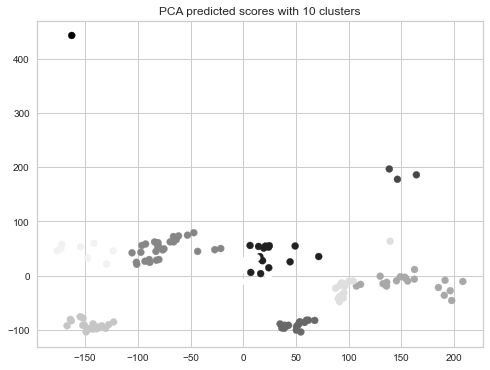

In [18]:
n_clusters = range(8,11)
for n_clusters in n_clusters:
    kmeans = cluster.KMeans(n_clusters = n_clusters , init = 'k-means++', random_state = 42)
    pred_kmeans = kmeans.fit_predict(data_s)
    pred_kmeans = pred_kmeans+1
    plt.scatter(datatrans[:,0],datatrans[:,1],c=pred_kmeans)
    plt.title(f'PCA predicted scores with {n_clusters} clusters')
    plt.show()

Using elbow method shows 8 cluster is good for clustering but I think 10 cluster is better to clustring regarding the line goes down slightly after k=10 
I want to check with silhouette to be sure for choosing right number cluters

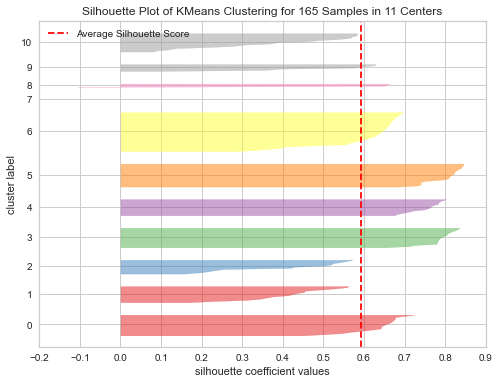

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 165 Samples in 11 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
# Instantiate the clustering model and visualizer 
model = KMeans(11)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show() 

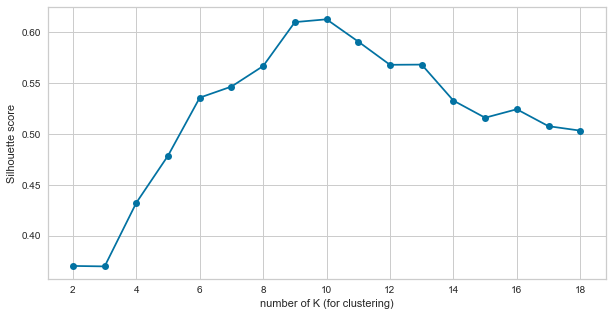

In [20]:
#silhouette coefficient
s_score = []

for cluster in range_clusters:
    km = KMeans(n_clusters=cluster)
    km.fit(X)
    cluster_labels = km.labels_
    s_score.append(metrics.silhouette_score(X, cluster_labels))
plt.figure(figsize=(10,5))
plt.plot(range_clusters,s_score,'o-')
plt.xlabel('number of K (for clustering)') 
plt.ylabel('Silhouette score') 
plt.show()

As I can see with silhouette score 10 clusters is better number for clustering

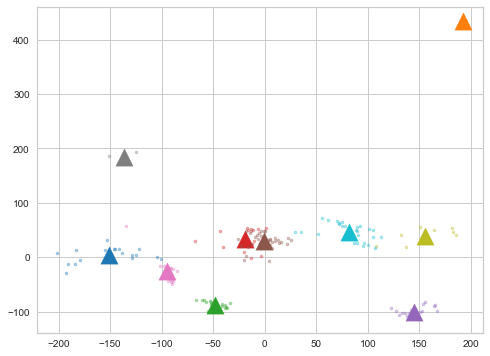

In [21]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(X)
display_cluster(X,km,num_clusters)

### tSNE

C:\Users\M.Toufani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


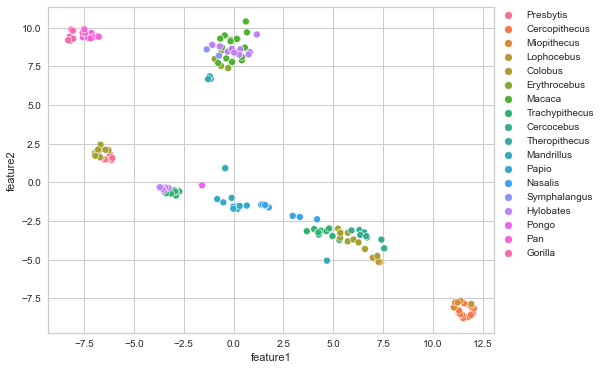

In [22]:
red_data = PCA(n_components=20,random_state=42).fit_transform(data_s)
red_data = pd.DataFrame(red_data)
x = red_data.iloc
tsne = TSNE(n_components=2, n_iter=1000, learning_rate='auto', perplexity=30).fit_transform(red_data)
tsne = pd.DataFrame(tsne)
tsne.columns = ['feature1', 'feature2']
tsne['sample'] = sel_data.index
sns.scatterplot(x='feature1', y='feature2', hue='sample', data=tsne)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

There are many overlapping I can see with the tSNE method for clustring

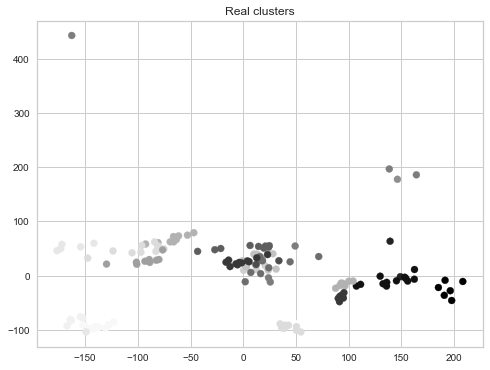

In [23]:
# Plotting real scores 
plt.figure()
classes=pd.factorize(classes)
plt.scatter(datatrans[:,0],datatrans[:,1],c=classes[0])
plt.title('Real clusters')
plt.show()

### DBscan

(150.0, 180.0)

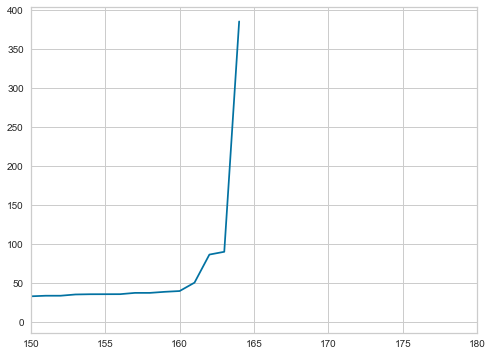

In [24]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlim(150,180)

I think 45 is a good value for using epsilon

Number of clusters : 8
Number of noise : 10


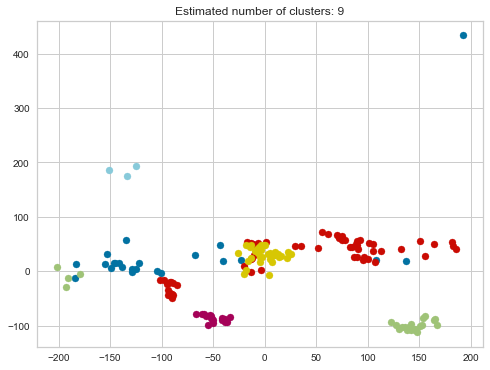

In [25]:
db = DBSCAN(eps=45, min_samples=3).fit(X)
labels = db.fit_predict(X)
n_clusters_=len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print('Number of clusters : {}'.format(n_clusters_))
print('Number of noise : {}'.format(list(db.labels_).count(-1)))
# Plot the clusters
for i in np.unique(labels):
    plt.scatter(X[labels == i , 0] , X[labels== i , 1])
plt.title("Estimated number of clusters: {}".format(len(np.unique(labels))))
plt.show() # showing the plot

dbsacn,k-means have a good clustering , but compare with the real cluster In My opinion and the way that visualization shows, k-mean is a better method for clustering in this case because also there are some overlap happening with dbscan method